In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from hmmlearn.hmm import GaussianHMM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import cleaning
import reinstancing


In [2]:
# Load and reinstance data
df_raw, users = cleaning.loadData('dataset_mood_smartphone.csv')
df_inst = reinstancing.reinstanceDataset(df_raw, users, period=5)
df_inst.head()


AS14.15  cannot provide subusers in ranges
AS14.20  cannot provide subusers in ranges


variable   activity  appCat.builtin  appCat.communication  \
AS14.01 0  0.163560     1370.685667           7502.876667   
        1  0.167999     1052.370500           7612.147000   
        2  0.152443     2607.564833           6929.466167   
        3  0.147191     2718.628833           6510.028333   
        4  0.134610     2643.197000           5181.341000   

variable   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
AS14.01 0            525.130333       40.585667     0.000000      29.202667   
        1            463.777500       39.364833     0.000000      30.910167   
        2            615.790667       50.713167    38.839333      30.910167   
        3            871.304500       43.479333    38.839333      30.910167   
        4            964.422167       37.795000    38.839333      30.408500   

variable   appCat.other  appCat.social  appCat.travel  appCat.unknown  \
AS14.01 0    125.598667    2597.354500     228.759167       39.203833   
        1     95.395500    2001.834667      84.070667       39.203833   
        2    116.696833    2014.019500     266.688000       39.203833   
        3    132.825333    1942.694333     275.427167       39.203833   
        4    134.066167    1433.370833     205.459667       50.283333   

variable   appCat.utilities  appCat.weather      call  circumplex.arousal  \
AS14.01 0        196.908500        5.064333  3.166667            0.458333   
        1        126.954333        5.064333  2.500000            0.375000   
        2        157.637000        5.064333  2.833333            0.291667   
        3        252.728833        0.000000  3.500000            0.125000   
        4        229.322833        0.000000  1.833333            0.000000   

variable   circumplex.valence      mood        screen       sms  nextday  
AS14.01 0            0.391304  6.416667  13973.567834  0.333333      6.6  
        1            0.478261  6.500000  13884.108333  0.500000      7.0  
        2            0.541667  6.625000  13680.996333  0.333333      6.4  
        3            0.500000  6.541667  13939.128000  0.500000      8.0  
        4            0.708333  6.958333  12185.105167  0.500000      7.5

In [3]:
# Feature engineering
df_feat = df_inst.copy()
df_feat['screen_log'] = np.log1p(df_feat['screen'])
df_feat['activity_log'] = np.log1p(df_feat['activity'])
df_feat['call_sms_ratio'] = df_feat['call'] / (df_feat['sms'] + 1)
df_feat = df_feat.dropna()
df_feat.head()


variable   activity  appCat.builtin  appCat.communication  \
AS14.01 0  0.163560     1370.685667           7502.876667   
        1  0.167999     1052.370500           7612.147000   
        2  0.152443     2607.564833           6929.466167   
        3  0.147191     2718.628833           6510.028333   
        4  0.134610     2643.197000           5181.341000   

variable   appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
AS14.01 0            525.130333       40.585667     0.000000      29.202667   
        1            463.777500       39.364833     0.000000      30.910167   
        2            615.790667       50.713167    38.839333      30.910167   
        3            871.304500       43.479333    38.839333      30.910167   
        4            964.422167       37.795000    38.839333      30.408500   

variable   appCat.other  appCat.social  appCat.travel  ...      call  \
AS14.01 0    125.598667    2597.354500     228.759167  ...  3.166667   
        1     95.395500    2001.834667      84.070667  ...  2.500000   
        2    116.696833    2014.019500     266.688000  ...  2.833333   
        3    132.825333    1942.694333     275.427167  ...  3.500000   
        4    134.066167    1433.370833     205.459667  ...  1.833333   

variable   circumplex.arousal  circumplex.valence      mood        screen  \
AS14.01 0            0.458333            0.391304  6.416667  13973.567834   
        1            0.375000            0.478261  6.500000  13884.108333   
        2            0.291667            0.541667  6.625000  13680.996333   
        3            0.125000            0.500000  6.541667  13939.128000   
        4            0.000000            0.708333  6.958333  12185.105167   

variable        sms  nextday  screen_log  activity_log  call_sms_ratio  
AS14.01 0  0.333333      6.6    9.544994      0.151485        2.375000  
        1  0.500000      7.0    9.538572      0.155292        1.666667  
        2  0.333333      6.4    9.523836      0.141884        2.125000  
        3  0.500000      8.0    9.542527      0.137316        2.333333  
        4  0.500000      7.5    9.408052      0.126289        1.222222  

[5 rows x 23 columns]

In [4]:
# Create 5 mood categories based on nextday
df_feat['mood_cat'] = pd.qcut(df_feat['nextday'], 5, labels=False)
print(df_feat['mood_cat'].value_counts(normalize=True))


mood_cat
1    0.307054
0    0.222683
3    0.206086
4    0.170124
2    0.094053
Name: proportion, dtype: float64


In [5]:
# Prepare features and target
X = df_feat.drop(columns=['nextday', 'mood_cat'])
y = df_feat['mood_cat']
# Split dataset (2/3 train, 1/3 test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, stratify=y, random_state=42
)


In [6]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def func():
    # Scaling factor for text
    scale = 1.4  # Adjust this value to scale all text elements

    # Set global font sizes using the scaling factor
    plt.rcParams.update({
        'font.size': 10 * scale,
        'axes.titlesize': 12 * scale,
        'axes.labelsize': 11 * scale,
        'xtick.labelsize': 10 * scale,
        'ytick.labelsize': 10 * scale,
        'legend.fontsize': 10 * scale,
        'figure.titlesize': 13 * scale
    })

    # 1) Raw counts
    plt.figure(figsize=(7, 5))
    sns.countplot(x='mood_cat', data=df_feat, palette='viridis')
    plt.title('Mood Category Counts')
    plt.xlabel('Mood Category (0–4)')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.savefig('mood_category_counts.pdf', format='pdf', bbox_inches='tight')
    plt.show()

    # 2) Relative frequencies
    freq = df_feat['mood_cat'].value_counts(normalize=True).sort_index() * 100
    plt.figure(figsize=(7, 5))
    sns.barplot(x=freq.index.astype(int), y=freq.values, palette='magma')
    plt.title('Mood Category Distribution (%)')
    plt.xlabel('Mood Category (0–4)')
    plt.ylabel('Percentage of Samples')
    for i, v in enumerate(freq.values):
        plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=9 * scale)
    plt.tight_layout()
    plt.savefig('mood_category_distribution.png', format='png', bbox_inches='tight')
    plt.show()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_22556\3857734266.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freq.index.astype(int), y=freq.values, palette='magma')


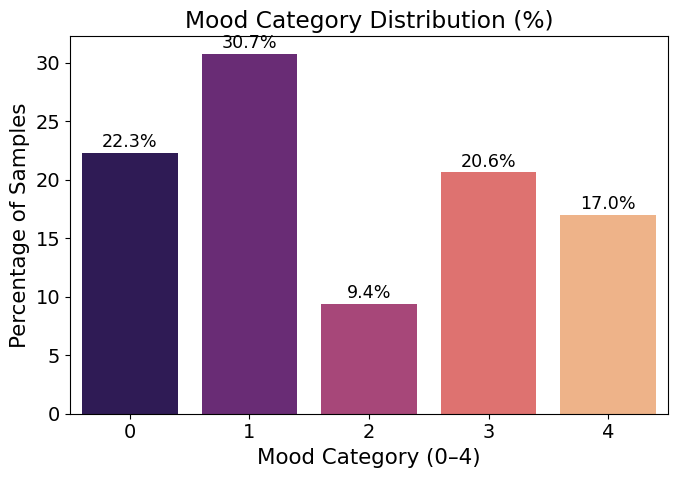

In [19]:
func()

# Random Forest

In [8]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.51      0.58        53
           1       0.40      0.62      0.49        74
           2       0.29      0.17      0.22        23
           3       0.33      0.26      0.29        50
           4       0.47      0.37      0.41        41

    accuracy                           0.44       241
   macro avg       0.43      0.39      0.40       241
weighted avg       0.45      0.44      0.43       241



# HMM

In [9]:
models = {}
for label in np.unique(y_train):
    # try 1 hidden state (you can bump this up)
    m = GaussianHMM(n_components=1,
                    covariance_type='full',
                    n_iter=100,
                    random_state=42)
    # HMM expects 2D array: (n_samples, n_features)
    m.fit(X_train_scaled[y_train == label])
    models[label] = m

c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\cluster\_kmeans.py:14

In [10]:
y_pred_hmm = []
for obs in X_test_scaled:
    # reshape to (1, n_feats)
    obs = obs.reshape(1, -1)
    scores = {lbl: mdl.score(obs) for lbl, mdl in models.items()}
    # pick the label whose HMM gives highest score
    y_pred_hmm.append(max(scores, key=scores.get))

In [11]:
print("HMM Classification Report:")
print(classification_report(y_test, y_pred_hmm))

HMM Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.60      0.52        53
           1       0.45      0.31      0.37        74
           2       0.25      0.52      0.34        23
           3       0.48      0.28      0.35        50
           4       0.43      0.44      0.43        41

    accuracy                           0.41       241
   macro avg       0.41      0.43      0.40       241
weighted avg       0.43      0.41      0.41       241



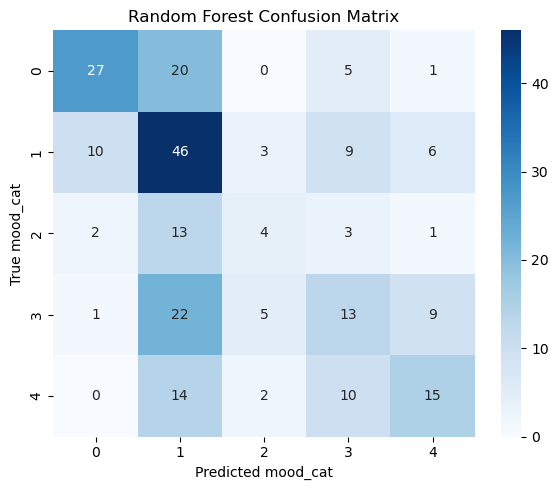

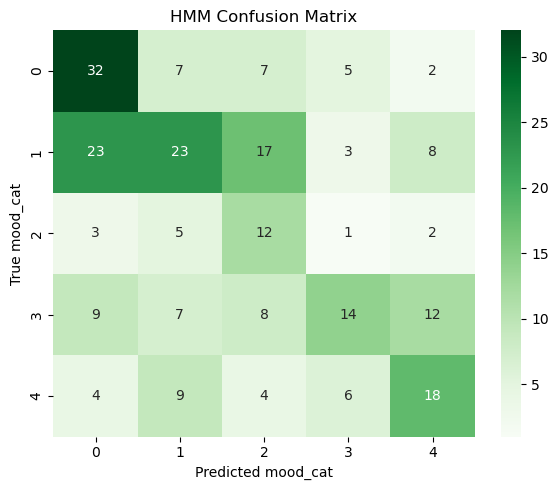

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) RF confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted mood_cat')
plt.ylabel('True mood_cat')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# 2) HMM confusion (if you used HMM)
# y_pred_hmm = ...  # ensure this exists
cm_hmm = confusion_matrix(y_test, y_pred_hmm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_hmm, annot=True, fmt='d', cmap='Greens',
            xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted mood_cat')
plt.ylabel('True mood_cat')
plt.title('HMM Confusion Matrix')
plt.tight_layout()
plt.show()

# RNN (not used)

In [13]:
# Prepare data for RNN
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)


In [14]:
# Build RNN model
model = Sequential([
    SimpleRNN(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                5568      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 5,893
Trainable params: 5,893
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train RNN model
history = model.fit(
    X_train_rnn, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)


Epoch 1/20
13/13 - 2s - loss: 1.8413 - accuracy: 0.1896 - val_loss: 1.5452 - val_accuracy: 0.2784 - 2s/epoch - 132ms/step
Epoch 2/20
13/13 - 0s - loss: 1.7452 - accuracy: 0.2234 - val_loss: 1.5093 - val_accuracy: 0.3402 - 53ms/epoch - 4ms/step
Epoch 3/20
13/13 - 0s - loss: 1.6801 - accuracy: 0.3039 - val_loss: 1.4860 - val_accuracy: 0.3402 - 56ms/epoch - 4ms/step
Epoch 4/20
13/13 - 0s - loss: 1.6422 - accuracy: 0.3039 - val_loss: 1.4753 - val_accuracy: 0.3196 - 54ms/epoch - 4ms/step
Epoch 5/20
13/13 - 0s - loss: 1.5687 - accuracy: 0.3299 - val_loss: 1.4655 - val_accuracy: 0.3093 - 54ms/epoch - 4ms/step
Epoch 6/20
13/13 - 0s - loss: 1.5539 - accuracy: 0.3325 - val_loss: 1.4610 - val_accuracy: 0.3608 - 55ms/epoch - 4ms/step
Epoch 7/20
13/13 - 0s - loss: 1.5670 - accuracy: 0.3065 - val_loss: 1.4602 - val_accuracy: 0.3814 - 53ms/epoch - 4ms/step
Epoch 8/20
13/13 - 0s - loss: 1.5463 - accuracy: 0.3273 - val_loss: 1.4604 - val_accuracy: 0.3814 - 54ms/epoch - 4ms/step
Epoch 9/20
13/13 - 0s - 

In [16]:
# Evaluate RNN model
print("RNN Evaluation:")
model.evaluate(X_test_rnn, y_test_cat, verbose=2)
y_pred_rnn = np.argmax(model.predict(X_test_rnn), axis=1)
print("RNN Classification Report:")
print(classification_report(y_test, y_pred_rnn))


RNN Evaluation:
8/8 - 0s - loss: 1.3678 - accuracy: 0.4232 - 37ms/epoch - 5ms/step
8/8 [==============================] - 0s 1ms/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        53
           1       0.38      0.66      0.48        74
           2       0.00      0.00      0.00        23
           3       0.41      0.26      0.32        50
           4       0.46      0.29      0.36        41

    accuracy                           0.42       241
   macro avg       0.35      0.35      0.34       241
weighted avg       0.39      0.42      0.39       241



c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lucas\anaconda3\envs\newest_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r